> ## YOLOv3 — You Only Look Once (Object Detection)

Хорошая статья по YOLO
https://towardsdatascience.com/review-yolov3-you-only-look-once-object-detection-eab75d7a1ba6


In [1]:
import math
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
random_stat = 123
np.random.seed(random_stat)

### Клонируем и билдим YOLOv3

In [3]:
!git clone https://github.com/pjreddie/darknet.git

!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

!cd darknet && make -j 999 -s
!cp darknet/darknet darknet_gpu

Cloning into 'darknet'...
remote: Enumerating objects: 5901, done.
remote: Total 5901 (delta 0), reused 0 (delta 0), pack-reused 5901
Receiving objects: 100% (5901/5901), 6.17 MiB | 0 bytes/s, done.
Resolving deltas: 100% (3925/3925), done.
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:947:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~


### Миграция данных для YOLOv3

In [4]:
DATA_DIR = "../input"

train_dcm_dir = os.path.join(DATA_DIR, "stage_1_train_images")
test_dcm_dir = os.path.join(DATA_DIR, "stage_1_test_images")

img_dir = os.path.join(os.getcwd(), "images")  
label_dir = os.path.join(os.getcwd(), "labels")  
metadata_dir = os.path.join(os.getcwd(), "metadata") 

cfg_dir = os.path.join(os.getcwd(), "cfg")
backup_dir = os.path.join(os.getcwd(), "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [5]:
!ls -shtl

total 2.2M
4.0K drwxr-xr-x  2 root root 4.0K Apr 14 05:02 backup
4.0K drwxr-xr-x  2 root root 4.0K Apr 14 05:02 cfg
4.0K drwxr-xr-x  2 root root 4.0K Apr 14 05:02 images
4.0K drwxr-xr-x  2 root root 4.0K Apr 14 05:02 labels
4.0K drwxr-xr-x  2 root root 4.0K Apr 14 05:02 metadata
1.9M -rwxr-xr-x  1 root root 1.9M Apr 14 05:02 darknet_gpu
4.0K drwxr-xr-x 13 root root 4.0K Apr 14 05:02 darknet
4.0K -rw-r--r--  1 root root  270 Apr 14 05:01 __output__.json
260K -rw-r--r--  1 root root 253K Apr 14 05:01 __notebook__.ipynb


In [6]:
annots = pd.read_csv(os.path.join(DATA_DIR, "stage_1_train_labels.csv"))
annots.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


### Генерация изображений и лэйблов для обучения YOLOv3

YOLOv3 нужен файл .txt для каждого изображения с лейблами изобраэжений, который выглядит следующим образом:

     <object-class_1> <x_1> <y_1> <width_1> <height_1>
     <object-class_2> <x_2> <y_2> <width_2> <height_2>

     <класс>
     <x>, <y>: это значения с плавающей точкой центральной координаты bbox, разделенные на ширину и высоту изображения соответственно.

     <w>, <h>: это ширина и высота bbox, разделенные на ширину и высоту изображения соответственно.

In [7]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna defualt image size
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
        
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

In [8]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

100%|██████████| 28989/28989 [01:56<00:00, 249.75it/s]


In [9]:
!du -sh images labels

954M	images
23M	labels


Посмотрим, что получилось

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



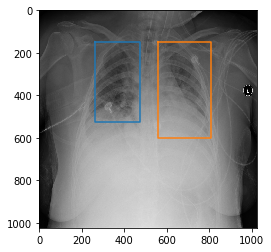

In [10]:
ex_patient_id = annots[annots.Target == 1].patientId.values[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

In [11]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [12]:
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))


write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)

The # of train set: 5093, The # of validation set: 566


In [13]:
def save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            save_img_from_dcm(test_dcm_dir, img_dir, patient_id)
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [14]:
test_dcm_fps = list(set(glob.glob(os.path.join(test_dcm_dir, '*.dcm'))))
test_dcm_fps = pd.Series(test_dcm_fps).apply(lambda dcm_fp: dcm_fp.strip().split("/")[-1].replace(".dcm",""))

save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, "te_list.txt", test_dcm_fps)

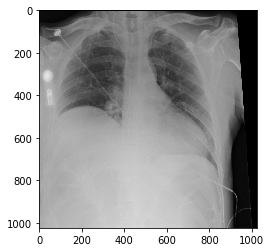

In [15]:
ex_patient_id = test_dcm_fps[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

## Подготовка файлов конфигурации для использования YOLOv3

Мы должны подготовить и изменить файлы конфигурации, а также принести предварительно обученные веса, необходимые для обучения:

1.   CFG / rsna.data
1.   CFG / rsna.names
1.   darknet53.conv.74
1.   CFG / rsna_yolov3.cfg_train

- cfg / rsna.data

Этот файл указывает на путь данных RSNA

     train: путь к текстовому файлу для обучения
     val: путь к проверочному текстовому файлу списка изображений
     имена: список имен классов RSNA
     резервное копирование: каталог, в котором обученные веса (контрольные точки) будут храниться в процессе обучения

In [16]:
data_extention_file_path = os.path.join(cfg_dir, 'rsna.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(metadata_dir, "tr_list.txt"),
               os.path.join(metadata_dir, "val_list.txt"),
               os.path.join(cfg_dir, 'rsna.names'),
               backup_dir)
    f.write(contents)

In [17]:
!cat cfg/rsna.data

classes= 1
train  = /kaggle/working/metadata/tr_list.txt
valid  = /kaggle/working/metadata/val_list.txt
names  = /kaggle/working/cfg/rsna.names
backup = /kaggle/working/backup
    

In [18]:
!echo "pneumonia" > cfg/rsna.names

Для обучения мы должны загрузить предварительно обученные веса моделей (darknet53.conv.74). 

In [19]:
!wget -q https://pjreddie.com/media/files/darknet53.conv.74

In [20]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=18ptTK4Vbeokqpux8Onr0OmwUP9ipmcYO" -O cfg/rsna_yolov3.cfg_train

In [21]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1OhnlV3s7r6xsEme6DKkNYjcYjsl-C_Av" -O train_log.txt

(0, 4.05)

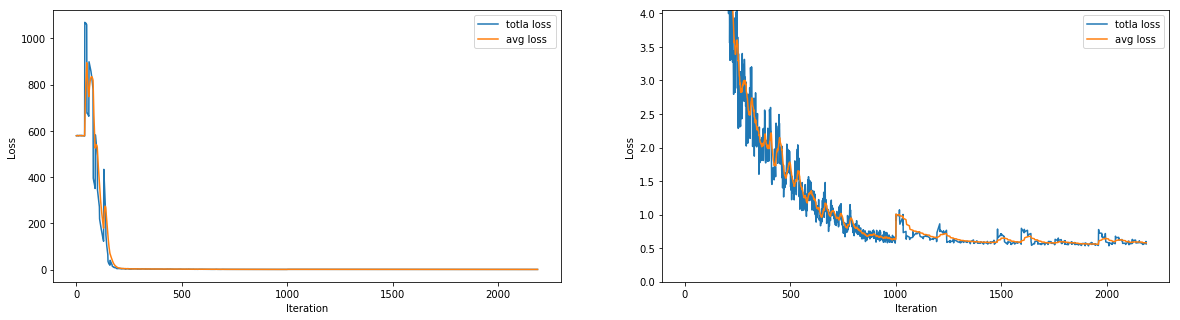

In [22]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="totla loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1,2,2)
sns.lineplot(iters, total_losses, label="totla loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim([0, 4.05])

In [23]:
ex_patient_id = annots[annots.Target == 1].patientId.values[2]
shutil.copy(ex_img_path, "test.jpg")
print(ex_patient_id)

00704310-78a8-4b38-8475-49f4573b2dbb


In [24]:
!wget --load-cookies /tmp/cookies.txt -q "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FDzMN-kGVYCvBeDKwemAazldSVkAEFyd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FDzMN-kGVYCvBeDKwemAazldSVkAEFyd" -O backup/rsna_yolov3_15300.weights && rm -rf /tmp/cookies.txt

In [25]:
!ls -alsth backup

total 236M
236M -rw-r--r-- 1 root root 235M Apr 14 05:04 rsna_yolov3_15300.weights
4.0K drwxr-xr-x 2 root root 4.0K Apr 14 05:04 .
4.0K drwxr-xr-x 8 root root 4.0K Apr 14 05:04 ..


In [26]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=10Yk6ZMAKGz5LeBbikciALy82aK3lX-57" -O cfg/rsna_yolov3.cfg_test

In [27]:
!cd darknet && ./darknet detector test ../cfg/rsna.data ../cfg/rsna_yolov3.cfg_test ../backup/rsna_yolov3_15300.weights ../test.jpg -thresh 0.005

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

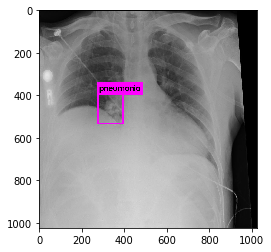

In [28]:
plt.imshow(cv2.imread("./darknet/predictions.jpg"))

In [29]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1-KTV7K9G1bl3SmnLnzmpkDyNt6tDmH7j" -O darknet.py

In [30]:
from darknet import *

In [31]:
threshold = 0.2

In [32]:
submit_file_path = "submission.csv"
cfg_path = os.path.join(cfg_dir, "rsna_yolov3.cfg_test")
weight_path = os.path.join(backup_dir, "rsna_yolov3_15300.weights")

test_img_list_path = os.path.join(metadata_dir, "te_list.txt")

In [33]:
gpu_index = 0
net = load_net(cfg_path.encode(),
               weight_path.encode(), 
               gpu_index)
meta = load_meta(data_extention_file_path.encode())

In [34]:
submit_dict = {"patientId": [], "PredictionString": []}

with open(test_img_list_path, "r") as test_img_list_f:
    for line in tqdm(test_img_list_f):
        patient_id = line.strip().split('/')[-1].strip().split('.')[0]

        infer_result = detect(net, meta, line.strip().encode(), thresh=threshold)

        submit_line = ""
        for e in infer_result:
            confi = e[1]
            w = e[2][2]
            h = e[2][3]
            x = e[2][0]-w/2
            y = e[2][1]-h/2
            submit_line += "{} {} {} {} {} ".format(confi, x, y, w, h)

        submit_dict["patientId"].append(patient_id)
        submit_dict["PredictionString"].append(submit_line)

pd.DataFrame(submit_dict).to_csv(submit_file_path, index=False)

1000it [01:05, 15.54it/s]


In [35]:
!rm -rf darknet images labels metadata backup cfg
!rm -rf train_log.txt darknet53.conv.74 darknet.py darknet_gpu
!rm -rf test.jpg
!rm -rf __pycache__ .ipynb_checkpoints

In [36]:
!ls -alsht

total 384K
4.0K drwxr-xr-x 2 root root 4.0K Apr 14 05:06 .
 96K -rw-r--r-- 1 root root  91K Apr 14 05:05 submission.csv
 20K -rw-r--r-- 1 root root  17K Apr 14 05:04 __output__.json
260K -rw-r--r-- 1 root root 253K Apr 14 05:01 __notebook__.ipynb
4.0K drwxr-xr-x 6 root root 4.0K Apr 14 05:01 ..
